In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import pandas as pd

BASE_DIR = "Warp-D"

# Labels are in train/labels/(file_name).txt in the format: class x_center y_center width height
labels_dir = os.path.join(BASE_DIR, "train/labels")
labels = os.listdir(labels_dir)

# Load the labels into a pandas dataframe
df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])

def load_labels(labels_dir):
  df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])
  for label in labels:
    with open(os.path.join(labels_dir, label), "r") as f:
      lines = f.readlines()
      for line in lines:
        line = line.strip().split(" ")
        if len(line) != 5:
          continue
        
        new_row = {"file_name": label.split(".")[0], 
              "class": line[0],
              "x_center": line[1], 
              "y_center": line[2], 
              "width": line[3], 
              "height": line[4]}
        
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
  return df

df = load_labels(labels_dir)

In [73]:
print(df.shape)
df.head()

(8823, 6)


,file_name,class,x_center,y_center,width,height
0,prepared_data_all_MGS_19-Oct_22-03-50,22,0.743750,0.464352,0.096875,0.247222
1,prepared_data_all_MGS_19-Oct_19-20-46,3,0.176302,0.106944,0.074479,0.212037
2,Robo_25-Mar_12-03-19,15,0.502344,0.213426,0.116146,0.345370
3,Robo_25-Mar_12-03-19,21,0.555208,0.826389,0.218750,0.158333
4,Robo_25-Mar_12-03-19,23,0.655208,0.578704,0.183333,0.398148


(540, 960, 3)
                    file_name class  x_center  y_center     width    height
1547  POSAD_1_11-Sep_09-43-28     7  0.534635  0.154630  0.180729  0.231481
1548  POSAD_1_11-Sep_09-43-28     2  0.410417  0.776852  0.197917  0.235185
1549  POSAD_1_11-Sep_09-43-28     4  0.296615  0.706944  0.108854  0.187963
1550  POSAD_1_11-Sep_09-43-28     8  0.360938  0.223148  0.095833  0.138889
1551  POSAD_1_11-Sep_09-43-28     0  0.616927  0.111574  0.098437  0.217593
1552  POSAD_1_11-Sep_09-43-28     4  0.472396  0.933796  0.119792  0.132407


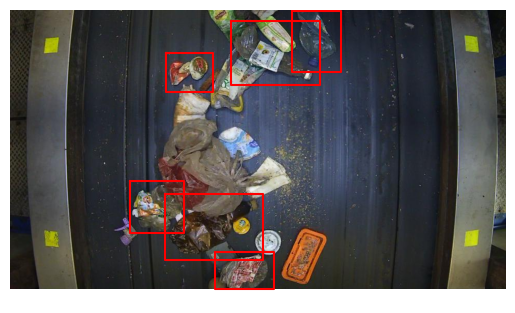

In [74]:
# Load example image and display
img_name = "POSAD_1_11-Sep_09-43-28"
# Filter the dataframe to only include the bounding boxes for the image we loaded
img_boxes = df[df["file_name"] == img_name]

img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
plt.imshow(img)
plt.axis("off")

print(img.shape)
print(img_boxes)

# Display bounding boxes
def disp_bb(img, img_boxes):
  for index, row in img_boxes.iterrows():
    # Values are normalized
    x_center = float(row["x_center"]) * img.shape[1]
    y_center = float(row["y_center"]) * img.shape[0]
    width = float(row["width"]) * img.shape[1]
    height = float(row["height"]) * img.shape[0]
    
    x1 = x_center - width/2
    x2 = x_center + width/2
    y1 = y_center - height/2
    y2 = y_center + height/2
    
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

disp_bb(img, img_boxes)
plt.show()

In [83]:
import random 


random.seed(42)

def get_random_image_patch(img, img_boxes, width, height):
    # display the image
    
    try:
        random_box = img_boxes.sample()    
        x_center = float(random_box.iloc[0]["x_center"]) * img.shape[1]
        y_center = float(random_box.iloc[0]["y_center"]) * img.shape[0]
    except ValueError:
        # create a random box
        x_center = random.uniform(0, 1)
        y_center = random.uniform(0, 1)
        
    x1 = x_center - width / 2
    x2 = x_center + width / 2
    y1 = y_center - height / 2
    y2 = y_center + height / 2
    
    # to integers
    x1, x2, y1, y2 = map(int, [x1, x2, y1, y2])
    
    cropped_img = img[y1:y2, x1:x2]

    return cropped_img


def cutmix(img, img_boxes, img2, img_2_boxes, threshold=0.3):
    img = np.copy(img)

    for i, bb in img_boxes.iterrows():
        # original bounding box
        x_center = float(bb["x_center"]) * img.shape[1]
        y_center = float(bb["y_center"]) * img.shape[0]
        width_bb = float(bb["width"])  * img.shape[1]
        height_bb = float(bb["height"])  * img.shape[0]
        
        # new bounding box - 30 percent of the original bounding box
        reduction_factor = np.sqrt(threshold)
        width = width_bb * reduction_factor
        height = height_bb * reduction_factor
        
        x1 = x_center - width / 2
        x2 = x_center + width / 2
        y1 = y_center - height / 2
        y2 = y_center + height / 2
        
        # move the new bounding box to a random location within the original bounding box
        random_x = random.uniform(0, width_bb/1.9)
        random_y = random.uniform(0, height_bb/1.9)
        
        img_x1 = x1 + random_x
        img_x2 = x2 + random_x
        img_y1 = y1 + random_y
        img_y2 = y2 + random_y
        
        # map to integers
        img_x1, img_x2, img_y1, img_y2 = map(int, [img_x1, img_x2, img_y1, img_y2])
                
        # loop through rectangle coords and set them to 0
        for y in range(img_y1, img_y2):
            for x in range(img_x1, img_x2):
                if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
                    img[y, x] = [0, 0, 0]
                    
        img_2 = get_random_image_patch(img2, img_2_boxes, img_x2 - img_x1, img_y2 - img_y1)

        # paste the new image onto the original image
        for y in range(img_y1, img_y2):
            for x in range(img_x1, img_x2):
                if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
                    if 0<= y - img_y1 < img_2.shape[0] and 0<= x - img_x1 < img_2.shape[1]:
                        img[y, x] = img_2[y - img_y1, x - img_x1]
       
        # plot the new bounding box - patched
        #plt.plot([img_x1, img_x2, img_x2, img_x1, img_x1], [img_y1, img_y1, img_y2, img_y2, img_y1], color="blue")
        
                    
    # y labels stay the same
    return img, img_boxes


(-0.5, 959.5, 539.5, -0.5)

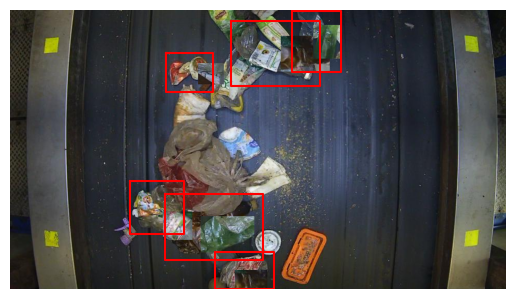

In [84]:
img_name = "POSAD_1_11-Sep_09-43-28"
img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
img_boxes = df[df["file_name"] == img_name]

img_2_name = "POSAD_1_13-Sep_01-00-20"
img_2 = plt.imread(os.path.join(BASE_DIR, "train/images/", img_2_name + ".jpg"))
img_2_boxes = df[df["file_name"] == img_2_name]

img, img_boxes = cutmix(img, img_boxes, img_2, img_2_boxes)

# Display bounding boxes
disp_bb(img, img_boxes)
plt.imshow(img)
plt.axis("off")

In [85]:
# read the test labels
test_labels_dir = os.path.join(BASE_DIR, "test/labels")   
labels = os.listdir(test_labels_dir)
df_test_labels = load_labels(test_labels_dir)
print(df_test_labels.shape)
df_test_labels.head()

(1551, 6)


,file_name,class,x_center,y_center,width,height
0,Monitoring_photo_test_25-Mar_11-09-16,22,0.380469,0.879630,0.132812,0.214815
1,Monitoring_photo_test_25-Mar_12-19-27,1,0.487760,0.734259,0.172396,0.285185
2,Monitoring_photo_test_25-Mar_12-19-27,1,0.145833,0.296759,0.113542,0.406481
3,Monitoring_photo_test_25-Mar_11-41-46,11,0.460156,0.487500,0.158854,0.254630
4,Monitoring_photo_test_25-Mar_11-41-46,0,0.348177,0.306944,0.155729,0.176852


In [91]:
from tqdm import tqdm

AUG_DIR = "Warp-D-Cutmix"

# Loop through dataset and apply cutmix
# For both test, train
for split in ["train", "test"]:
  
  if split == "test":
    df_labels = df_test_labels
  else:
    df_labels = df
  
  
  images_dir = os.path.join(BASE_DIR, split, "images")
  images_aug_dir = os.path.join(AUG_DIR, split, "images")
  images = os.listdir(images_dir)

  for image in tqdm(images, desc=f"Processing {split} set"):
    
    img = plt.imread(os.path.join(images_dir, image))
    img_boxes = df_labels[df_labels["file_name"] == image.split(".")[0]]
    
    # randomly pick img_2 
    img_2_name = random.choice(images)
    img_2 = plt.imread(os.path.join(images_dir, img_2_name))
    img_2_boxes = df_labels[df_labels["file_name"] == img_2_name.split(".")[0]]

    img, boxes = cutmix(img, img_boxes, img_2, img_2_boxes)
    plt.imsave(os.path.join(images_aug_dir, image), img)
    # Save bounding boxes to txt
    # Drop the first column
    boxes = boxes.drop(columns=["file_name"])
    boxes.to_csv(os.path.join(AUG_DIR, split, "labels", image.split(".")[0] + ".txt"), header=False, index=False, sep=" ")

print("Finished processing")

Processing test set: 100%|██████████| 522/522 [00:37<00:00, 14.05it/s]

Finished processing


(-0.5, 1919.5, 1079.5, -0.5)

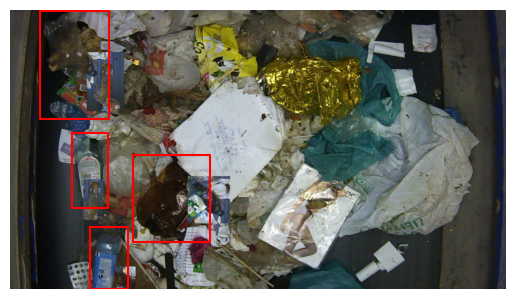

In [92]:
# training set example
CUTMIX_DIR = "Warp-D-Cutmix"
img_name = "Monitoring_photo_04-Mar_04-21-55"
img = plt.imread(os.path.join(CUTMIX_DIR, "train/images/", img_name + ".jpg"))
img_boxes = df[df["file_name"] == img_name]

# Display bounding boxes
disp_bb(img, img_boxes)
plt.imshow(img)
plt.axis("off")

(-0.5, 1919.5, 1079.5, -0.5)

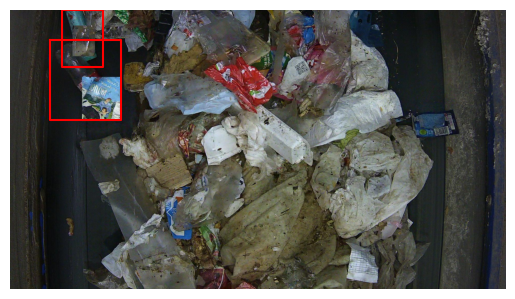

In [95]:
# test set example
img_name = "Monitoring_photo_2_test_25-Mar_11-11-15"
img = plt.imread(os.path.join(CUTMIX_DIR, "test/images/", img_name + ".jpg"))

img_boxes = df_test_labels[df_test_labels["file_name"] == img_name]

# Display bounding boxes
disp_bb(img, img_boxes)
plt.imshow(img)
plt.axis("off")
